In [1]:
import argparse
from itertools import product as iterprod
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from argparse import ArgumentParser
import time
from datetime import datetime
from tqdm.autonotebook import tqdm
import pandas as pd

import matplotlib.pyplot as plt



/tmp/ipykernel_2395410/3724148964.py:12: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
import utils.data67_processing as dp


from utils.UNeXt import UNet
from utils.loss_inference import loss_function_dict

import utils.nb_utils as nb_utils

import pprint

np.random.seed(11) # for reproducibility
torch.manual_seed(11)


%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
batch_size = 8
num_workers = 4

# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
pin_memory = True if torch.cuda.is_available() else False

In [4]:
device


device(type='cuda', index=0)

# Build dataset

In [5]:
# Dataset
directory  = '/mnt/d/lding/FA/analysis_results/pFAK_zyxin_20230423/combined_npy_grouped_normalized/'

test_cells = 'cell_3'


in_channels  = [[6]] # Example: [[4], [4,6], [4,6,7]]. Channel 4 is mask, 6 is zyxin, 7 is other protein (here actin)
out_channels = (7)
transform_kwargs = {'crop_size': 512,
                    'output_channels': out_channels,
                    'norm_output': {'rescale': 1, 'threshold': 0.0004}
                    }

dataset_kwargs = { 
                    'root': directory,
                    'force_load': False,
                    'test_split': 'bycell',
                    'test_cells': test_cells,
                    'in_channels': in_channels, 
                    'out_channels': out_channels, 
                    'transform_kwargs': transform_kwargs,
                    'frames_to_keep': 256,
                    'input_baseline_normalization': 'none', # Comment on what these do
                    'output_baseline_normalization': 'none',
                    'remake_dataset_csv': True
                     }


dataset = dp.CellDataset( **dataset_kwargs )

train_loader = dataset.get_loader(dataset.train_indices, batch_size, num_workers, pin_memory)
validation_loader = dataset.get_loader(dataset.test_indices, batch_size, num_workers, pin_memory)

{'crop_size': 512, 'output_channels': 7, 'norm_output': {'rescale': 1, 'threshold': 0.0004}}


# Some visualizations of the training data

The dataset class gets items by looking into a dataframe (`dataset.info`) where the folders and filenames are stored. Folders correspond to single cells, and each file is a frame of the time series. 

`dataset.info` contains the normalization values which the data is normalized by before it is passed to the NN. Forces are normalized by `dataset.info.F_mean` and the zyxin signal is normalized by `dataset.info.zyxin_baseline_out` and `dataset.info.zyxin_baseline_in`. Details about how these are generated can be found in the DataProcessing notebook.
    


In [6]:
df = dataset.info.copy()

df.head(10)

folder                                  filename  frame  \
0  cell_3  combined_Control_zxyin_pFAK_cell_200.npy    200   
1  cell_3  combined_Control_zxyin_pFAK_cell_201.npy    201   
2  cell_3  combined_Control_zxyin_pFAK_cell_202.npy    202   
3  cell_3  combined_Control_zxyin_pFAK_cell_203.npy    203   
4  cell_3  combined_Control_zxyin_pFAK_cell_204.npy    204   
5  cell_3  combined_Control_zxyin_pFAK_cell_205.npy    205   
6  cell_3  combined_Control_zxyin_pFAK_cell_206.npy    206   
7  cell_3  combined_Control_zxyin_pFAK_cell_207.npy    207   
8  cell_3  combined_Control_zxyin_pFAK_cell_208.npy    208   
9  cell_3  combined_Control_zxyin_pFAK_cell_209.npy    209   

                                                root  
0  /mnt/d/lding/FA/analysis_results/pFAK_zyxin_20...  
1  /mnt/d/lding/FA/analysis_results/pFAK_zyxin_20...  
2  /mnt/d/lding/FA/analysis_results/pFAK_zyxin_20...  
3  /mnt/d/lding/FA/analysis_results/pFAK_zyxin_20...  
4  /mnt/d/lding/FA/analysis_results/pFAK_zyxin_20...  
5  /mnt/d/lding/FA/analysis_results/pFAK_zyxin_20...  
6  /mnt/d/lding/FA/analysis_results/pFAK_zyxin_20...  
7  /mnt/d/lding/FA/analysis_results/pFAK_zyxin_20...  
8  /mnt/d/lding/FA/analysis_results/pFAK_zyxin_20...  
9  /mnt/d/lding/FA/analysis_results/pFAK_zyxin_20...

In [7]:
# Print test cells: 
print(dataset.test_cells)
print(dataset.test_indices)

{'test_cells': ['cell_3']}
[48 18 89 93 22 44 45  6 24 75 67 69 26  0  1 68 51 20 38 41 60 62 21  5
 33 59 50 28 35 25 82  9 39 88 46 90 85 16  3 12 63 15 40 14 61 17  4 49
 86 80 98]


In [8]:
dataset.info

folder                                  filename  frame  \
0    cell_3  combined_Control_zxyin_pFAK_cell_200.npy    200   
1    cell_3  combined_Control_zxyin_pFAK_cell_201.npy    201   
2    cell_3  combined_Control_zxyin_pFAK_cell_202.npy    202   
3    cell_3  combined_Control_zxyin_pFAK_cell_203.npy    203   
4    cell_3  combined_Control_zxyin_pFAK_cell_204.npy    204   
..      ...                                       ...    ...   
595  cell_6      combined_Y27_zxyin_pFAK_cell_295.npy    295   
596  cell_6      combined_Y27_zxyin_pFAK_cell_296.npy    296   
597  cell_6      combined_Y27_zxyin_pFAK_cell_297.npy    297   
598  cell_6      combined_Y27_zxyin_pFAK_cell_298.npy    298   
599  cell_6      combined_Y27_zxyin_pFAK_cell_299.npy    299   

                                                  root  
0    /mnt/d/lding/FA/analysis_results/pFAK_zyxin_20...  
1    /mnt/d/lding/FA/analysis_results/pFAK_zyxin_20...  
2    /mnt/d/lding/FA/analysis_results/pFAK_zyxin_20...  
3    /mnt/d/lding/FA/analysis_results/pFAK_zyxin_20...  
4    /mnt/d/lding/FA/analysis_results/pFAK_zyxin_20...  
..                                                 ...  
595  /mnt/d/lding/FA/analysis_results/pFAK_zyxin_20...  
596  /mnt/d/lding/FA/analysis_results/pFAK_zyxin_20...  
597  /mnt/d/lding/FA/analysis_results/pFAK_zyxin_20...  
598  /mnt/d/lding/FA/analysis_results/pFAK_zyxin_20...  
599  /mnt/d/lding/FA/analysis_results/pFAK_zyxin_20...  

[600 rows x 4 columns]

In [9]:
cell = 'cell_1'
frame = 10

idx = dataset.info.index[(dataset.info.folder==cell)&(dataset.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.
print(idx)

dataset.out_channels

sample = dataset[idx]

210


{'mask': torch.Size([1, 512, 512]), 'zyxin': torch.Size([1, 512, 512]), 'actin': torch.Size([1, 512, 512]), 'weight': torch.Size([1, 512, 512]), 'output': torch.Size([1, 512, 512])}


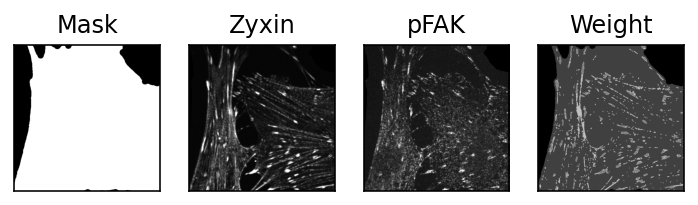

In [10]:
fig,ax=plt.subplots(1,4,figsize=(2*3, 4*2), dpi=144)

print({key: sample[key].shape for key in sample.keys()})

ax[0].set_title('Mask')
ax[0].imshow(sample['mask'].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)
ax[1].set_title('Zyxin')
ax[1].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)
ax[2].set_title('pFAK')
ax[2].imshow(sample['actin'].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)
ax[3].set_title('Weight')
ax[3].imshow(sample['weight'][0,:,:].squeeze(), origin='lower', cmap='gray', vmax=4, vmin=0)


for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])

In [11]:
sample['actin'].max()

tensor(1.)

### Build U-Net model with ConvNext blocks

In [12]:
n_lyr  = 3 # number of downsampling layers
ds_krnl= 4 # downsample kernel
n_ch   = 4 # number of channels in the beginning of the network
n_blocks = 4 # number of ConvNext blocks, wherever ConvNext blocks are used

prepend_hparams = {'start_channel': 1, 'resnet_channel': n_ch, 'end_channel': n_ch, 'N_blocks': n_blocks,                                         # Args for architecture
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1} # Args for ConvNext blocks
encoder_hparams = {'n_ch': n_ch, 'n_layers': n_lyr, 'N_node_blocks': n_blocks, 'N_skip_blocks': n_blocks,
                    'downsample_kwargs': {'kernel': ds_krnl, 'activation': 'gelu', 'batchnorm': 1},
                    'interlayer_kwargs': {'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1}
                    }
decoder_hparams = {'n_layers': n_lyr, 'N_node_blocks': n_blocks, 'upsample_kernel': ds_krnl,
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1}
append_hparams = {'start_channel': n_ch, 'resnet_channel': n_ch, 'end_channel': 2, 'N_blocks': n_blocks,
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 8, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1} 
optimizer_hparams = {'LR': 0.001, 'schedule_rate': 0.99}
loss_hparams = {'loss_type': 'w_mse',
                'exp_weight': 0.0,
                'strainenergy_regularization': 0.0,
                'exp_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30},
                'reg_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30},
                'loss_kwargs': {'max_force': 8.}
               }


models = {}
for protein in ['zyxin1','zyxin2']:
    modelname = 'datanormed_model_zyxin2pfakweighted_100ep'

    logger_params = {'log_dir': f'./tensorboard_logs/{modelname}', 
                     'image_epoch_freq': 10,
                     'image_callbacks': 'vectorfield,hists',
                     'save_model_freq': 4}

    # Actually build model:
    model_kwargs={
                    'input_type':  protein[:-1], 
                    'prepend_hparams': prepend_hparams, 
                    'encoder_hparams': encoder_hparams, 
                    'decoder_hparams': decoder_hparams, 
                    'append_hparams': append_hparams, 
                    'optimizer_hparams': optimizer_hparams,
                    'loss_hparams': loss_hparams,
                    'logger_params': logger_params,
                    'name': modelname}


    model = UNet( **model_kwargs, model_idx=0)
    model.to(device)
    
    models[protein] = model


In [13]:
models

{'zyxin1': UNet(
   (layers_encode): ModuleList(
     (0): ModuleList(
       (0-3): 4 x ConvNextCell(
         (conv0): Conv2d(4, 4, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=4)
         (conv1): Conv2d(4, 16, kernel_size=(1, 1), stride=(1, 1))
         (conv2): Conv2d(16, 4, kernel_size=(1, 1), stride=(1, 1))
         (bn): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (act): GELU(approximate='none')
       )
       (4): DownsampleLayer(
         (conv): Conv2d(4, 8, kernel_size=(4, 4), stride=(4, 4))
         (bn): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (act): GELU(approximate='none')
       )
     )
     (1): ModuleList(
       (0-3): 4 x ConvNextCell(
         (conv0): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=8)
         (conv1): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
         (conv2): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
  

In [14]:
protein[:-1]

'zyxin'

# Perform training

In [15]:
save_models = True
n_epochs = 100

pbar = tqdm(total=n_epochs*(np.minimum(dataset.frames_to_keep, len(dataset.train_indices))/batch_size))

t0 = time.time()
for e in range(n_epochs):
    pbar.set_description(f'Epoch {e}')
    loss_values_train = {}
    loss_values_val = {}

    for mkey in models.keys():
        models[mkey].reset_running_train_loss()
        models[mkey].reset_running_val_loss()

    for sample in train_loader: 
        for key in sample:
            sample[key] = sample[key].to(device)
        
        for mkey in models.keys():
            models[mkey].training_step(sample, epoch=e) # loss.backward() and optimizer step occur in here
        
        pbar.update(1)

    for sample in validation_loader:
        for key in sample:
            sample[key] = sample[key].to(device)
    
        for mkey in models.keys():
            models[mkey].validation_step(sample, epoch=e)

    for mkey in models.keys():
        models[mkey].scheduler.step()
        print(models[mkey].get_running_val_loss())
    print("Epoch %u:\t Time: %0.2f \t(per epoch: %0.2f)"%(e, time.time()-t0, (time.time()-t0)/(e+1)))
    
    # SAVE
    if save_models:
        # Log in tensorboard
        for mkey in models.keys():
            models[mkey].log_scalars(epoch=e) 
            
        # Save models
        if e%(logger_params['save_model_freq'])==0 or e==n_epochs-1: 
            torch.save({'model': model.state_dict(),
                        'model_kwargs': model_kwargs,
                        'model_name': model.name,
                        'model_idx': model.index,
                        'dataset_kwargs': dataset_kwargs,
                        'test_cells': dataset.test_cells,
                        }, 
                       os.path.join( model.logdir, 'model.pt') )


Epoch 1:   1%|          | 32/3200.0 [02:35<1:17:49,  1.47s/it]

{'w_mse_loss': tensor(0.1013, device='cuda:0'), 'mse_loss': tensor(0.1393, device='cuda:0'), 'base_loss': tensor(0.1013, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'w_mse_loss': tensor(0.1738, device='cuda:0'), 'mse_loss': tensor(0.9058, device='cuda:0'), 'base_loss': tensor(0.1738, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 0:	 Time: 155.28 	(per epoch: 155.28)


Epoch 2:   2%|▏         | 64/3200.0 [03:08<33:23,  1.57it/s]   

{'w_mse_loss': tensor(0.0792, device='cuda:0'), 'mse_loss': tensor(0.1101, device='cuda:0'), 'base_loss': tensor(0.0792, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'w_mse_loss': tensor(0.1283, device='cuda:0'), 'mse_loss': tensor(6.2370, device='cuda:0'), 'base_loss': tensor(0.1283, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 1:	 Time: 188.08 	(per epoch: 94.04)


Epoch 3:   3%|▎         | 96/3200.0 [03:39<30:53,  1.67it/s]  

{'w_mse_loss': tensor(0.0756, device='cuda:0'), 'mse_loss': tensor(0.1065, device='cuda:0'), 'base_loss': tensor(0.0756, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'w_mse_loss': tensor(0.0939, device='cuda:0'), 'mse_loss': tensor(0.6477, device='cuda:0'), 'base_loss': tensor(0.0939, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 2:	 Time: 219.71 	(per epoch: 73.24)


Epoch 4:   4%|▍         | 128/3200.0 [04:13<31:28,  1.63it/s]  

{'w_mse_loss': tensor(0.0799, device='cuda:0'), 'mse_loss': tensor(3.1856, device='cuda:0'), 'base_loss': tensor(0.0799, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'w_mse_loss': tensor(0.0895, device='cuda:0'), 'mse_loss': tensor(0.1918, device='cuda:0'), 'base_loss': tensor(0.0895, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 3:	 Time: 253.46 	(per epoch: 63.36)


Epoch 5:   5%|▌         | 160/3200.0 [04:46<31:06,  1.63it/s]  

{'w_mse_loss': tensor(0.0753, device='cuda:0'), 'mse_loss': tensor(0.1678, device='cuda:0'), 'base_loss': tensor(0.0753, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'w_mse_loss': tensor(0.0877, device='cuda:0'), 'mse_loss': tensor(2.0219, device='cuda:0'), 'base_loss': tensor(0.0877, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 4:	 Time: 286.07 	(per epoch: 57.21)


Epoch 6:   6%|▌         | 192/3200.0 [05:20<32:14,  1.55it/s]  

{'w_mse_loss': tensor(0.0728, device='cuda:0'), 'mse_loss': tensor(4.8034, device='cuda:0'), 'base_loss': tensor(0.0728, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'w_mse_loss': tensor(0.0833, device='cuda:0'), 'mse_loss': tensor(0.1741, device='cuda:0'), 'base_loss': tensor(0.0833, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 5:	 Time: 320.49 	(per epoch: 53.42)


Epoch 7:   7%|▋         | 224/3200.0 [05:55<32:17,  1.54it/s]  

{'w_mse_loss': tensor(0.0661, device='cuda:0'), 'mse_loss': tensor(0.0831, device='cuda:0'), 'base_loss': tensor(0.0661, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'w_mse_loss': tensor(0.0744, device='cuda:0'), 'mse_loss': tensor(2.9567, device='cuda:0'), 'base_loss': tensor(0.0744, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 6:	 Time: 355.66 	(per epoch: 50.81)


Epoch 8:   8%|▊         | 256/3200.0 [06:30<31:44,  1.55it/s]  

{'w_mse_loss': tensor(0.0802, device='cuda:0'), 'mse_loss': tensor(0.0756, device='cuda:0'), 'base_loss': tensor(0.0802, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'w_mse_loss': tensor(0.0865, device='cuda:0'), 'mse_loss': tensor(0.1059, device='cuda:0'), 'base_loss': tensor(0.0865, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 7:	 Time: 390.89 	(per epoch: 48.86)


Epoch 9:   9%|▉         | 288/3200.0 [07:04<30:01,  1.62it/s]  

{'w_mse_loss': tensor(0.0674, device='cuda:0'), 'mse_loss': tensor(0.7477, device='cuda:0'), 'base_loss': tensor(0.0674, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'w_mse_loss': tensor(0.0995, device='cuda:0'), 'mse_loss': tensor(26.2827, device='cuda:0'), 'base_loss': tensor(0.0995, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 8:	 Time: 424.93 	(per epoch: 47.21)


Epoch 10:  10%|█         | 320/3200.0 [07:38<31:31,  1.52it/s] 

{'w_mse_loss': tensor(0.0650, device='cuda:0'), 'mse_loss': tensor(1.2608, device='cuda:0'), 'base_loss': tensor(0.0650, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'w_mse_loss': tensor(0.0693, device='cuda:0'), 'mse_loss': tensor(0.0884, device='cuda:0'), 'base_loss': tensor(0.0693, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 9:	 Time: 458.77 	(per epoch: 45.88)


Epoch 11:  11%|█         | 352/3200.0 [08:12<29:09,  1.63it/s]  

{'w_mse_loss': tensor(0.0748, device='cuda:0'), 'mse_loss': tensor(0.0736, device='cuda:0'), 'base_loss': tensor(0.0748, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'w_mse_loss': tensor(0.0812, device='cuda:0'), 'mse_loss': tensor(0.2691, device='cuda:0'), 'base_loss': tensor(0.0812, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 10:	 Time: 492.90 	(per epoch: 44.81)


Epoch 12:  12%|█▏        | 384/3200.0 [08:46<29:02,  1.62it/s]  

{'w_mse_loss': tensor(0.0698, device='cuda:0'), 'mse_loss': tensor(1.6355, device='cuda:0'), 'base_loss': tensor(0.0698, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'w_mse_loss': tensor(0.0771, device='cuda:0'), 'mse_loss': tensor(10.3288, device='cuda:0'), 'base_loss': tensor(0.0771, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 11:	 Time: 526.89 	(per epoch: 43.91)


Epoch 13:  13%|█▎        | 416/3200.0 [09:21<30:07,  1.54it/s]  

{'w_mse_loss': tensor(0.0726, device='cuda:0'), 'mse_loss': tensor(3.3161, device='cuda:0'), 'base_loss': tensor(0.0726, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'w_mse_loss': tensor(0.1725, device='cuda:0'), 'mse_loss': tensor(31.0161, device='cuda:0'), 'base_loss': tensor(0.1725, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 12:	 Time: 561.19 	(per epoch: 43.17)


Epoch 14:  14%|█▍        | 448/3200.0 [09:55<29:08,  1.57it/s]  

{'w_mse_loss': tensor(0.0682, device='cuda:0'), 'mse_loss': tensor(0.2503, device='cuda:0'), 'base_loss': tensor(0.0682, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'w_mse_loss': tensor(0.0724, device='cuda:0'), 'mse_loss': tensor(0.2003, device='cuda:0'), 'base_loss': tensor(0.0724, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 13:	 Time: 595.17 	(per epoch: 42.51)


Epoch 15:  15%|█▌        | 480/3200.0 [10:29<28:32,  1.59it/s]  

{'w_mse_loss': tensor(0.0715, device='cuda:0'), 'mse_loss': tensor(0.2331, device='cuda:0'), 'base_loss': tensor(0.0715, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'w_mse_loss': tensor(0.0744, device='cuda:0'), 'mse_loss': tensor(0.0893, device='cuda:0'), 'base_loss': tensor(0.0744, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 14:	 Time: 629.49 	(per epoch: 41.97)


Epoch 16:  16%|█▌        | 512/3200.0 [11:04<29:02,  1.54it/s]  

{'w_mse_loss': tensor(0.0677, device='cuda:0'), 'mse_loss': tensor(1.0033, device='cuda:0'), 'base_loss': tensor(0.0677, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'w_mse_loss': tensor(0.0793, device='cuda:0'), 'mse_loss': tensor(3.3001, device='cuda:0'), 'base_loss': tensor(0.0793, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 15:	 Time: 664.11 	(per epoch: 41.51)


Epoch 17:  17%|█▋        | 544/3200.0 [11:38<29:31,  1.50it/s]  

{'w_mse_loss': tensor(0.0664, device='cuda:0'), 'mse_loss': tensor(0.1316, device='cuda:0'), 'base_loss': tensor(0.0664, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'w_mse_loss': tensor(0.0698, device='cuda:0'), 'mse_loss': tensor(0.0840, device='cuda:0'), 'base_loss': tensor(0.0698, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 16:	 Time: 698.01 	(per epoch: 41.06)


Epoch 18:  18%|█▊        | 576/3200.0 [12:11<28:26,  1.54it/s]  

{'w_mse_loss': tensor(0.0630, device='cuda:0'), 'mse_loss': tensor(0.3920, device='cuda:0'), 'base_loss': tensor(0.0630, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'w_mse_loss': tensor(0.0677, device='cuda:0'), 'mse_loss': tensor(5.2721, device='cuda:0'), 'base_loss': tensor(0.0677, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 17:	 Time: 731.47 	(per epoch: 40.64)


Epoch 19:  19%|█▉        | 608/3200.0 [12:45<28:50,  1.50it/s]  

{'w_mse_loss': tensor(0.0727, device='cuda:0'), 'mse_loss': tensor(0.0844, device='cuda:0'), 'base_loss': tensor(0.0727, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'w_mse_loss': tensor(0.0758, device='cuda:0'), 'mse_loss': tensor(8.1453, device='cuda:0'), 'base_loss': tensor(0.0758, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 18:	 Time: 765.50 	(per epoch: 40.29)


Epoch 20:  20%|██        | 640/3200.0 [13:19<27:21,  1.56it/s]  

{'w_mse_loss': tensor(0.0614, device='cuda:0'), 'mse_loss': tensor(0.0618, device='cuda:0'), 'base_loss': tensor(0.0614, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'w_mse_loss': tensor(0.0658, device='cuda:0'), 'mse_loss': tensor(4.7821, device='cuda:0'), 'base_loss': tensor(0.0658, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 19:	 Time: 799.12 	(per epoch: 39.96)


Epoch 21:  21%|██        | 672/3200.0 [13:52<26:01,  1.62it/s]  

{'w_mse_loss': tensor(0.0780, device='cuda:0'), 'mse_loss': tensor(0.0646, device='cuda:0'), 'base_loss': tensor(0.0780, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'w_mse_loss': tensor(0.0787, device='cuda:0'), 'mse_loss': tensor(0.0755, device='cuda:0'), 'base_loss': tensor(0.0787, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 20:	 Time: 832.69 	(per epoch: 39.65)


Epoch 22:  22%|██▏       | 704/3200.0 [14:26<26:40,  1.56it/s]  

{'w_mse_loss': tensor(0.0643, device='cuda:0'), 'mse_loss': tensor(0.0675, device='cuda:0'), 'base_loss': tensor(0.0643, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'w_mse_loss': tensor(0.0685, device='cuda:0'), 'mse_loss': tensor(3.5322, device='cuda:0'), 'base_loss': tensor(0.0685, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 21:	 Time: 866.66 	(per epoch: 39.39)


Epoch 23:  23%|██▎       | 736/3200.0 [15:00<26:29,  1.55it/s]  

{'w_mse_loss': tensor(0.0714, device='cuda:0'), 'mse_loss': tensor(1.2701, device='cuda:0'), 'base_loss': tensor(0.0714, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'w_mse_loss': tensor(0.0678, device='cuda:0'), 'mse_loss': tensor(4.1707, device='cuda:0'), 'base_loss': tensor(0.0678, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 22:	 Time: 900.41 	(per epoch: 39.15)


Epoch 24:  24%|██▍       | 768/3200.0 [15:33<25:57,  1.56it/s]  

{'w_mse_loss': tensor(0.0613, device='cuda:0'), 'mse_loss': tensor(0.0562, device='cuda:0'), 'base_loss': tensor(0.0613, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'w_mse_loss': tensor(0.0642, device='cuda:0'), 'mse_loss': tensor(0.0739, device='cuda:0'), 'base_loss': tensor(0.0642, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 23:	 Time: 933.20 	(per epoch: 38.88)


Epoch 25:  25%|██▌       | 800/3200.0 [16:05<24:50,  1.61it/s]  

{'w_mse_loss': tensor(0.0696, device='cuda:0'), 'mse_loss': tensor(2.5171, device='cuda:0'), 'base_loss': tensor(0.0696, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'w_mse_loss': tensor(0.0711, device='cuda:0'), 'mse_loss': tensor(4.7571, device='cuda:0'), 'base_loss': tensor(0.0711, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 24:	 Time: 965.86 	(per epoch: 38.63)


Epoch 26:  26%|██▌       | 832/3200.0 [16:39<25:44,  1.53it/s]  

{'w_mse_loss': tensor(0.0753, device='cuda:0'), 'mse_loss': tensor(0.0736, device='cuda:0'), 'base_loss': tensor(0.0753, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'w_mse_loss': tensor(0.0756, device='cuda:0'), 'mse_loss': tensor(8.2608, device='cuda:0'), 'base_loss': tensor(0.0756, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 25:	 Time: 999.15 	(per epoch: 38.43)


Epoch 27:  27%|██▋       | 864/3200.0 [17:12<24:47,  1.57it/s]  

{'w_mse_loss': tensor(0.0622, device='cuda:0'), 'mse_loss': tensor(0.0567, device='cuda:0'), 'base_loss': tensor(0.0622, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'w_mse_loss': tensor(0.0643, device='cuda:0'), 'mse_loss': tensor(0.7233, device='cuda:0'), 'base_loss': tensor(0.0643, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 26:	 Time: 1032.07 	(per epoch: 38.22)


Epoch 28:  28%|██▊       | 896/3200.0 [17:46<25:14,  1.52it/s]  

{'w_mse_loss': tensor(0.0656, device='cuda:0'), 'mse_loss': tensor(0.1401, device='cuda:0'), 'base_loss': tensor(0.0656, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'w_mse_loss': tensor(0.0728, device='cuda:0'), 'mse_loss': tensor(0.0620, device='cuda:0'), 'base_loss': tensor(0.0728, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 27:	 Time: 1066.40 	(per epoch: 38.09)


Epoch 29:  29%|██▉       | 928/3200.0 [18:19<24:10,  1.57it/s]  

{'w_mse_loss': tensor(0.0650, device='cuda:0'), 'mse_loss': tensor(0.0625, device='cuda:0'), 'base_loss': tensor(0.0650, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'w_mse_loss': tensor(0.0701, device='cuda:0'), 'mse_loss': tensor(10.2209, device='cuda:0'), 'base_loss': tensor(0.0701, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 28:	 Time: 1099.75 	(per epoch: 37.92)


Epoch 30:  30%|███       | 960/3200.0 [18:52<22:55,  1.63it/s]  

{'w_mse_loss': tensor(0.0657, device='cuda:0'), 'mse_loss': tensor(0.0610, device='cuda:0'), 'base_loss': tensor(0.0657, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'w_mse_loss': tensor(0.5779, device='cuda:0'), 'mse_loss': tensor(72.4791, device='cuda:0'), 'base_loss': tensor(0.5779, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 29:	 Time: 1132.79 	(per epoch: 37.76)


Epoch 31:  31%|███       | 992/3200.0 [19:26<23:38,  1.56it/s]  

{'w_mse_loss': tensor(0.0641, device='cuda:0'), 'mse_loss': tensor(0.2453, device='cuda:0'), 'base_loss': tensor(0.0641, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'w_mse_loss': tensor(0.0688, device='cuda:0'), 'mse_loss': tensor(0.0756, device='cuda:0'), 'base_loss': tensor(0.0688, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 30:	 Time: 1166.69 	(per epoch: 37.64)


Epoch 32:  32%|███▏      | 1024/3200.0 [19:59<22:57,  1.58it/s] 

{'w_mse_loss': tensor(0.0687, device='cuda:0'), 'mse_loss': tensor(0.1083, device='cuda:0'), 'base_loss': tensor(0.0687, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.022580645161290325}
{'w_mse_loss': tensor(0.0732, device='cuda:0'), 'mse_loss': tensor(0.0710, device='cuda:0'), 'base_loss': tensor(0.0732, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.022580645161290325}
Epoch 31:	 Time: 1199.76 	(per epoch: 37.49)


Epoch 33:  33%|███▎      | 1056/3200.0 [20:33<22:10,  1.61it/s]  

{'w_mse_loss': tensor(0.0557, device='cuda:0'), 'mse_loss': tensor(0.0598, device='cuda:0'), 'base_loss': tensor(0.0557, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.04516129032258065}
{'w_mse_loss': tensor(0.0716, device='cuda:0'), 'mse_loss': tensor(23.5643, device='cuda:0'), 'base_loss': tensor(0.0716, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.04516129032258065}
Epoch 32:	 Time: 1233.50 	(per epoch: 37.38)


Epoch 34:  34%|███▍      | 1088/3200.0 [21:06<22:18,  1.58it/s]  

{'w_mse_loss': tensor(0.0607, device='cuda:0'), 'mse_loss': tensor(0.3164, device='cuda:0'), 'base_loss': tensor(0.0607, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.06774193548387096}
{'w_mse_loss': tensor(0.0669, device='cuda:0'), 'mse_loss': tensor(0.1919, device='cuda:0'), 'base_loss': tensor(0.0669, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.06774193548387096}
Epoch 33:	 Time: 1266.14 	(per epoch: 37.24)


Epoch 35:  35%|███▌      | 1120/3200.0 [21:39<21:52,  1.59it/s]  

{'w_mse_loss': tensor(0.0578, device='cuda:0'), 'mse_loss': tensor(0.0645, device='cuda:0'), 'base_loss': tensor(0.0578, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0903225806451613}
{'w_mse_loss': tensor(0.0638, device='cuda:0'), 'mse_loss': tensor(0.0758, device='cuda:0'), 'base_loss': tensor(0.0638, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0903225806451613}
Epoch 34:	 Time: 1299.49 	(per epoch: 37.13)


Epoch 36:  36%|███▌      | 1152/3200.0 [22:13<21:50,  1.56it/s]  

{'w_mse_loss': tensor(0.0637, device='cuda:0'), 'mse_loss': tensor(0.0687, device='cuda:0'), 'base_loss': tensor(0.0637, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.11290322580645161}
{'w_mse_loss': tensor(0.0631, device='cuda:0'), 'mse_loss': tensor(0.0662, device='cuda:0'), 'base_loss': tensor(0.0631, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.11290322580645161}
Epoch 35:	 Time: 1333.94 	(per epoch: 37.05)


Epoch 37:  37%|███▋      | 1184/3200.0 [22:48<20:50,  1.61it/s]  

{'w_mse_loss': tensor(0.0663, device='cuda:0'), 'mse_loss': tensor(0.1441, device='cuda:0'), 'base_loss': tensor(0.0663, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.13548387096774192}
{'w_mse_loss': tensor(0.1206, device='cuda:0'), 'mse_loss': tensor(32.4300, device='cuda:0'), 'base_loss': tensor(0.1206, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.13548387096774192}
Epoch 36:	 Time: 1368.03 	(per epoch: 36.97)


Epoch 38:  38%|███▊      | 1216/3200.0 [23:21<21:18,  1.55it/s]  

{'w_mse_loss': tensor(0.0688, device='cuda:0'), 'mse_loss': tensor(0.0864, device='cuda:0'), 'base_loss': tensor(0.0688, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.15806451612903225}
{'w_mse_loss': tensor(0.0756, device='cuda:0'), 'mse_loss': tensor(6.7287, device='cuda:0'), 'base_loss': tensor(0.0756, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.15806451612903225}
Epoch 37:	 Time: 1401.31 	(per epoch: 36.88)


Epoch 39:  39%|███▉      | 1248/3200.0 [23:55<20:25,  1.59it/s]  

{'w_mse_loss': tensor(0.0577, device='cuda:0'), 'mse_loss': tensor(0.0691, device='cuda:0'), 'base_loss': tensor(0.0577, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.1806451612903226}
{'w_mse_loss': tensor(0.0596, device='cuda:0'), 'mse_loss': tensor(0.0648, device='cuda:0'), 'base_loss': tensor(0.0596, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.1806451612903226}
Epoch 38:	 Time: 1435.10 	(per epoch: 36.80)


Epoch 40:  40%|████      | 1280/3200.0 [24:27<19:47,  1.62it/s]  

{'w_mse_loss': tensor(0.0696, device='cuda:0'), 'mse_loss': tensor(0.0750, device='cuda:0'), 'base_loss': tensor(0.0696, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.2032258064516129}
{'w_mse_loss': tensor(0.0731, device='cuda:0'), 'mse_loss': tensor(0.0719, device='cuda:0'), 'base_loss': tensor(0.0731, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.2032258064516129}
Epoch 39:	 Time: 1467.44 	(per epoch: 36.69)


Epoch 41:  41%|████      | 1312/3200.0 [25:01<20:23,  1.54it/s]  

{'w_mse_loss': tensor(0.0633, device='cuda:0'), 'mse_loss': tensor(0.0676, device='cuda:0'), 'base_loss': tensor(0.0633, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.22580645161290322}
{'w_mse_loss': tensor(0.1431, device='cuda:0'), 'mse_loss': tensor(44.9287, device='cuda:0'), 'base_loss': tensor(0.1431, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.22580645161290322}
Epoch 40:	 Time: 1501.11 	(per epoch: 36.61)


Epoch 42:  42%|████▏     | 1344/3200.0 [25:35<20:12,  1.53it/s]  

{'w_mse_loss': tensor(0.0654, device='cuda:0'), 'mse_loss': tensor(0.0682, device='cuda:0'), 'base_loss': tensor(0.0654, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.24838709677419357}
{'w_mse_loss': tensor(0.0656, device='cuda:0'), 'mse_loss': tensor(0.0728, device='cuda:0'), 'base_loss': tensor(0.0656, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.24838709677419357}
Epoch 41:	 Time: 1535.20 	(per epoch: 36.55)


Epoch 43:  43%|████▎     | 1376/3200.0 [26:07<19:11,  1.58it/s]  

{'w_mse_loss': tensor(0.0647, device='cuda:0'), 'mse_loss': tensor(0.4659, device='cuda:0'), 'base_loss': tensor(0.0647, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.27096774193548384}
{'w_mse_loss': tensor(0.0660, device='cuda:0'), 'mse_loss': tensor(1.6771, device='cuda:0'), 'base_loss': tensor(0.0660, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.27096774193548384}
Epoch 42:	 Time: 1567.83 	(per epoch: 36.46)


Epoch 44:  44%|████▍     | 1408/3200.0 [26:41<18:30,  1.61it/s]  

{'w_mse_loss': tensor(0.0565, device='cuda:0'), 'mse_loss': tensor(0.0672, device='cuda:0'), 'base_loss': tensor(0.0565, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.2935483870967742}
{'w_mse_loss': tensor(1.2041, device='cuda:0'), 'mse_loss': tensor(90.5512, device='cuda:0'), 'base_loss': tensor(1.2041, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.2935483870967742}
Epoch 43:	 Time: 1601.12 	(per epoch: 36.39)


Epoch 45:  45%|████▌     | 1440/3200.0 [27:14<17:57,  1.63it/s]  

{'w_mse_loss': tensor(0.0635, device='cuda:0'), 'mse_loss': tensor(0.0597, device='cuda:0'), 'base_loss': tensor(0.0635, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.3161290322580645}
{'w_mse_loss': tensor(0.0674, device='cuda:0'), 'mse_loss': tensor(0.4717, device='cuda:0'), 'base_loss': tensor(0.0674, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.3161290322580645}
Epoch 44:	 Time: 1634.72 	(per epoch: 36.33)


Epoch 46:  46%|████▌     | 1472/3200.0 [27:48<18:36,  1.55it/s]  

{'w_mse_loss': tensor(0.0693, device='cuda:0'), 'mse_loss': tensor(0.0839, device='cuda:0'), 'base_loss': tensor(0.0693, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.33870967741935487}
{'w_mse_loss': tensor(0.0710, device='cuda:0'), 'mse_loss': tensor(0.0759, device='cuda:0'), 'base_loss': tensor(0.0710, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.33870967741935487}
Epoch 45:	 Time: 1668.94 	(per epoch: 36.28)


Epoch 47:  47%|████▋     | 1504/3200.0 [28:21<17:18,  1.63it/s]  

{'w_mse_loss': tensor(0.0746, device='cuda:0'), 'mse_loss': tensor(0.2185, device='cuda:0'), 'base_loss': tensor(0.0746, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.3612903225806452}
{'w_mse_loss': tensor(0.0676, device='cuda:0'), 'mse_loss': tensor(3.2644, device='cuda:0'), 'base_loss': tensor(0.0676, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.3612903225806452}
Epoch 46:	 Time: 1701.52 	(per epoch: 36.20)


Epoch 48:  48%|████▊     | 1536/3200.0 [28:55<18:19,  1.51it/s]  

{'w_mse_loss': tensor(0.0592, device='cuda:0'), 'mse_loss': tensor(0.3978, device='cuda:0'), 'base_loss': tensor(0.0592, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.3838709677419354}
{'w_mse_loss': tensor(0.0614, device='cuda:0'), 'mse_loss': tensor(0.0638, device='cuda:0'), 'base_loss': tensor(0.0614, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.3838709677419354}
Epoch 47:	 Time: 1735.98 	(per epoch: 36.17)


Epoch 49:  49%|████▉     | 1568/3200.0 [29:29<16:58,  1.60it/s]  

{'w_mse_loss': tensor(0.0751, device='cuda:0'), 'mse_loss': tensor(0.2055, device='cuda:0'), 'base_loss': tensor(0.0751, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.4064516129032258}
{'w_mse_loss': tensor(0.0699, device='cuda:0'), 'mse_loss': tensor(0.0648, device='cuda:0'), 'base_loss': tensor(0.0699, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.4064516129032258}
Epoch 48:	 Time: 1769.42 	(per epoch: 36.11)


Epoch 50:  50%|█████     | 1600/3200.0 [30:02<16:31,  1.61it/s]  

{'w_mse_loss': tensor(0.0628, device='cuda:0'), 'mse_loss': tensor(0.2595, device='cuda:0'), 'base_loss': tensor(0.0628, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.4290322580645161}
{'w_mse_loss': tensor(0.0685, device='cuda:0'), 'mse_loss': tensor(0.0742, device='cuda:0'), 'base_loss': tensor(0.0685, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.4290322580645161}
Epoch 49:	 Time: 1802.89 	(per epoch: 36.06)


Epoch 51:  51%|█████     | 1632/3200.0 [30:37<17:13,  1.52it/s]  

{'w_mse_loss': tensor(0.0623, device='cuda:0'), 'mse_loss': tensor(0.1341, device='cuda:0'), 'base_loss': tensor(0.0623, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.45161290322580644}
{'w_mse_loss': tensor(0.0689, device='cuda:0'), 'mse_loss': tensor(6.8773, device='cuda:0'), 'base_loss': tensor(0.0689, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.45161290322580644}
Epoch 50:	 Time: 1837.37 	(per epoch: 36.03)


Epoch 52:  52%|█████▏    | 1664/3200.0 [31:11<16:35,  1.54it/s]  

{'w_mse_loss': tensor(0.0612, device='cuda:0'), 'mse_loss': tensor(0.1075, device='cuda:0'), 'base_loss': tensor(0.0612, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.4741935483870968}
{'w_mse_loss': tensor(0.0643, device='cuda:0'), 'mse_loss': tensor(3.7246, device='cuda:0'), 'base_loss': tensor(0.0643, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.4741935483870968}
Epoch 51:	 Time: 1871.38 	(per epoch: 35.99)


Epoch 53:  53%|█████▎    | 1696/3200.0 [31:43<15:32,  1.61it/s]  

{'w_mse_loss': tensor(0.0602, device='cuda:0'), 'mse_loss': tensor(0.0782, device='cuda:0'), 'base_loss': tensor(0.0602, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.49677419354838714}
{'w_mse_loss': tensor(0.0627, device='cuda:0'), 'mse_loss': tensor(0.0691, device='cuda:0'), 'base_loss': tensor(0.0627, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.49677419354838714}
Epoch 52:	 Time: 1903.38 	(per epoch: 35.91)


Epoch 54:  54%|█████▍    | 1728/3200.0 [32:16<15:17,  1.60it/s]  

{'w_mse_loss': tensor(0.0638, device='cuda:0'), 'mse_loss': tensor(0.1363, device='cuda:0'), 'base_loss': tensor(0.0638, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.5193548387096775}
{'w_mse_loss': tensor(0.1095, device='cuda:0'), 'mse_loss': tensor(27.6443, device='cuda:0'), 'base_loss': tensor(0.1095, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.5193548387096775}
Epoch 53:	 Time: 1936.75 	(per epoch: 35.87)


Epoch 55:  55%|█████▌    | 1760/3200.0 [32:50<14:58,  1.60it/s]  

{'w_mse_loss': tensor(0.0606, device='cuda:0'), 'mse_loss': tensor(0.0823, device='cuda:0'), 'base_loss': tensor(0.0606, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.5419354838709677}
{'w_mse_loss': tensor(0.0697, device='cuda:0'), 'mse_loss': tensor(0.7851, device='cuda:0'), 'base_loss': tensor(0.0697, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.5419354838709677}
Epoch 54:	 Time: 1970.86 	(per epoch: 35.83)


Epoch 56:  56%|█████▌    | 1792/3200.0 [33:25<15:05,  1.55it/s]  

{'w_mse_loss': tensor(0.0592, device='cuda:0'), 'mse_loss': tensor(0.0662, device='cuda:0'), 'base_loss': tensor(0.0592, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.564516129032258}
{'w_mse_loss': tensor(0.0655, device='cuda:0'), 'mse_loss': tensor(0.0646, device='cuda:0'), 'base_loss': tensor(0.0655, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.564516129032258}
Epoch 55:	 Time: 2005.59 	(per epoch: 35.81)


Epoch 57:  57%|█████▋    | 1824/3200.0 [33:58<14:29,  1.58it/s]  

{'w_mse_loss': tensor(0.0619, device='cuda:0'), 'mse_loss': tensor(0.5494, device='cuda:0'), 'base_loss': tensor(0.0619, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.5870967741935484}
{'w_mse_loss': tensor(0.0669, device='cuda:0'), 'mse_loss': tensor(3.2188, device='cuda:0'), 'base_loss': tensor(0.0669, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.5870967741935484}
Epoch 56:	 Time: 2038.31 	(per epoch: 35.76)


Epoch 58:  58%|█████▊    | 1856/3200.0 [34:31<14:15,  1.57it/s]  

{'w_mse_loss': tensor(0.0792, device='cuda:0'), 'mse_loss': tensor(0.2857, device='cuda:0'), 'base_loss': tensor(0.0792, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.6096774193548387}
{'w_mse_loss': tensor(0.0734, device='cuda:0'), 'mse_loss': tensor(0.0664, device='cuda:0'), 'base_loss': tensor(0.0734, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.6096774193548387}
Epoch 57:	 Time: 2071.51 	(per epoch: 35.72)


Epoch 59:  59%|█████▉    | 1888/3200.0 [35:05<13:45,  1.59it/s]  

{'w_mse_loss': tensor(0.0657, device='cuda:0'), 'mse_loss': tensor(0.1692, device='cuda:0'), 'base_loss': tensor(0.0657, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.632258064516129}
{'w_mse_loss': tensor(0.0634, device='cuda:0'), 'mse_loss': tensor(0.0702, device='cuda:0'), 'base_loss': tensor(0.0634, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.632258064516129}
Epoch 58:	 Time: 2105.66 	(per epoch: 35.69)


Epoch 60:  60%|██████    | 1920/3200.0 [35:39<13:31,  1.58it/s]  

{'w_mse_loss': tensor(0.0697, device='cuda:0'), 'mse_loss': tensor(0.0957, device='cuda:0'), 'base_loss': tensor(0.0697, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.6548387096774193}
{'w_mse_loss': tensor(0.0727, device='cuda:0'), 'mse_loss': tensor(13.8501, device='cuda:0'), 'base_loss': tensor(0.0727, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.6548387096774193}
Epoch 59:	 Time: 2139.44 	(per epoch: 35.66)


Epoch 61:  61%|██████    | 1952/3200.0 [36:13<13:18,  1.56it/s]  

{'w_mse_loss': tensor(0.0597, device='cuda:0'), 'mse_loss': tensor(0.0702, device='cuda:0'), 'base_loss': tensor(0.0597, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.6774193548387097}
{'w_mse_loss': tensor(0.0622, device='cuda:0'), 'mse_loss': tensor(0.0602, device='cuda:0'), 'base_loss': tensor(0.0622, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.6774193548387097}
Epoch 60:	 Time: 2173.40 	(per epoch: 35.63)


Epoch 62:  62%|██████▏   | 1984/3200.0 [36:47<12:57,  1.56it/s]  

{'w_mse_loss': tensor(0.0609, device='cuda:0'), 'mse_loss': tensor(0.0715, device='cuda:0'), 'base_loss': tensor(0.0609, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.7}
{'w_mse_loss': tensor(0.0725, device='cuda:0'), 'mse_loss': tensor(2.3268, device='cuda:0'), 'base_loss': tensor(0.0725, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.7}
Epoch 61:	 Time: 2207.47 	(per epoch: 35.60)


Epoch 63:  63%|██████▎   | 2016/3200.0 [37:20<12:25,  1.59it/s]  

{'w_mse_loss': tensor(0.0675, device='cuda:0'), 'mse_loss': tensor(0.6963, device='cuda:0'), 'base_loss': tensor(0.0675, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.7225806451612904}
{'w_mse_loss': tensor(9.0943, device='cuda:0'), 'mse_loss': tensor(236.1661, device='cuda:0'), 'base_loss': tensor(9.0943, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.7225806451612904}
Epoch 62:	 Time: 2240.28 	(per epoch: 35.56)


Epoch 64:  64%|██████▍   | 2048/3200.0 [37:53<12:17,  1.56it/s]  

{'w_mse_loss': tensor(0.0689, device='cuda:0'), 'mse_loss': tensor(0.2235, device='cuda:0'), 'base_loss': tensor(0.0689, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.7451612903225806}
{'w_mse_loss': tensor(0.0720, device='cuda:0'), 'mse_loss': tensor(0.1243, device='cuda:0'), 'base_loss': tensor(0.0720, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.7451612903225806}
Epoch 63:	 Time: 2273.44 	(per epoch: 35.52)


Epoch 65:  65%|██████▌   | 2080/3200.0 [38:26<11:50,  1.58it/s]  

{'w_mse_loss': tensor(0.0612, device='cuda:0'), 'mse_loss': tensor(0.0835, device='cuda:0'), 'base_loss': tensor(0.0612, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.7677419354838708}
{'w_mse_loss': tensor(0.0674, device='cuda:0'), 'mse_loss': tensor(4.6997, device='cuda:0'), 'base_loss': tensor(0.0674, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.7677419354838708}
Epoch 64:	 Time: 2306.43 	(per epoch: 35.48)


Epoch 66:  66%|██████▌   | 2112/3200.0 [39:01<11:47,  1.54it/s]  

{'w_mse_loss': tensor(0.0679, device='cuda:0'), 'mse_loss': tensor(0.5124, device='cuda:0'), 'base_loss': tensor(0.0679, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.7903225806451613}
{'w_mse_loss': tensor(0.0716, device='cuda:0'), 'mse_loss': tensor(0.0799, device='cuda:0'), 'base_loss': tensor(0.0716, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.7903225806451613}
Epoch 65:	 Time: 2341.34 	(per epoch: 35.47)


Epoch 67:  67%|██████▋   | 2144/3200.0 [39:34<11:15,  1.56it/s]  

{'w_mse_loss': tensor(0.0650, device='cuda:0'), 'mse_loss': tensor(0.0789, device='cuda:0'), 'base_loss': tensor(0.0650, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.8129032258064516}
{'w_mse_loss': tensor(0.0659, device='cuda:0'), 'mse_loss': tensor(0.0606, device='cuda:0'), 'base_loss': tensor(0.0659, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.8129032258064516}
Epoch 66:	 Time: 2374.62 	(per epoch: 35.44)


Epoch 68:  68%|██████▊   | 2176/3200.0 [40:08<11:00,  1.55it/s]  

{'w_mse_loss': tensor(0.0631, device='cuda:0'), 'mse_loss': tensor(0.1466, device='cuda:0'), 'base_loss': tensor(0.0631, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.835483870967742}
{'w_mse_loss': tensor(0.0659, device='cuda:0'), 'mse_loss': tensor(4.9939, device='cuda:0'), 'base_loss': tensor(0.0659, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.835483870967742}
Epoch 67:	 Time: 2408.81 	(per epoch: 35.42)


Epoch 69:  69%|██████▉   | 2208/3200.0 [40:42<10:47,  1.53it/s]

{'w_mse_loss': tensor(0.0591, device='cuda:0'), 'mse_loss': tensor(0.0722, device='cuda:0'), 'base_loss': tensor(0.0591, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.8580645161290322}
{'w_mse_loss': tensor(0.0617, device='cuda:0'), 'mse_loss': tensor(3.6803, device='cuda:0'), 'base_loss': tensor(0.0617, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.8580645161290322}
Epoch 68:	 Time: 2442.41 	(per epoch: 35.40)


Epoch 70:  70%|███████   | 2240/3200.0 [41:16<10:50,  1.48it/s]

{'w_mse_loss': tensor(0.0585, device='cuda:0'), 'mse_loss': tensor(0.0698, device='cuda:0'), 'base_loss': tensor(0.0585, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.8806451612903223}
{'w_mse_loss': tensor(0.0617, device='cuda:0'), 'mse_loss': tensor(0.0617, device='cuda:0'), 'base_loss': tensor(0.0617, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.8806451612903223}
Epoch 69:	 Time: 2476.46 	(per epoch: 35.38)


Epoch 71:  71%|███████   | 2272/3200.0 [41:49<09:38,  1.61it/s]

{'w_mse_loss': tensor(0.0625, device='cuda:0'), 'mse_loss': tensor(0.0702, device='cuda:0'), 'base_loss': tensor(0.0625, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.9032258064516129}
{'w_mse_loss': tensor(0.0715, device='cuda:0'), 'mse_loss': tensor(0.0735, device='cuda:0'), 'base_loss': tensor(0.0715, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.9032258064516129}
Epoch 70:	 Time: 2509.77 	(per epoch: 35.35)


Epoch 72:  72%|███████▏  | 2304/3200.0 [42:22<09:10,  1.63it/s]

{'w_mse_loss': tensor(0.0659, device='cuda:0'), 'mse_loss': tensor(0.0596, device='cuda:0'), 'base_loss': tensor(0.0659, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.9258064516129034}
{'w_mse_loss': tensor(0.0682, device='cuda:0'), 'mse_loss': tensor(14.1258, device='cuda:0'), 'base_loss': tensor(0.0682, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.9258064516129034}
Epoch 71:	 Time: 2542.76 	(per epoch: 35.32)


Epoch 73:  73%|███████▎  | 2336/3200.0 [42:56<09:18,  1.55it/s]

{'w_mse_loss': tensor(0.0746, device='cuda:0'), 'mse_loss': tensor(0.3468, device='cuda:0'), 'base_loss': tensor(0.0746, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.9483870967741936}
{'w_mse_loss': tensor(0.5082, device='cuda:0'), 'mse_loss': tensor(31.3269, device='cuda:0'), 'base_loss': tensor(0.5082, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.9483870967741936}
Epoch 72:	 Time: 2576.17 	(per epoch: 35.29)


Epoch 74:  74%|███████▍  | 2368/3200.0 [43:29<08:44,  1.59it/s]

{'w_mse_loss': tensor(0.0681, device='cuda:0'), 'mse_loss': tensor(0.3643, device='cuda:0'), 'base_loss': tensor(0.0681, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.9709677419354837}
{'w_mse_loss': tensor(0.0741, device='cuda:0'), 'mse_loss': tensor(0.0816, device='cuda:0'), 'base_loss': tensor(0.0741, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.9709677419354837}
Epoch 73:	 Time: 2609.01 	(per epoch: 35.26)


Epoch 75:  75%|███████▌  | 2400/3200.0 [44:01<08:27,  1.58it/s]

{'w_mse_loss': tensor(0.0594, device='cuda:0'), 'mse_loss': tensor(0.0939, device='cuda:0'), 'base_loss': tensor(0.0594, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.9935483870967743}
{'w_mse_loss': tensor(0.0646, device='cuda:0'), 'mse_loss': tensor(1.5426, device='cuda:0'), 'base_loss': tensor(0.0646, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.9935483870967743}
Epoch 74:	 Time: 2641.94 	(per epoch: 35.23)


Epoch 76:  76%|███████▌  | 2432/3200.0 [44:34<08:01,  1.60it/s]

{'w_mse_loss': tensor(0.0622, device='cuda:0'), 'mse_loss': tensor(0.2153, device='cuda:0'), 'base_loss': tensor(0.0622, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.0161290322580645}
{'w_mse_loss': tensor(0.0642, device='cuda:0'), 'mse_loss': tensor(0.2871, device='cuda:0'), 'base_loss': tensor(0.0642, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.0161290322580645}
Epoch 75:	 Time: 2674.91 	(per epoch: 35.20)


Epoch 77:  77%|███████▋  | 2464/3200.0 [45:09<08:05,  1.52it/s]

{'w_mse_loss': tensor(0.0758, device='cuda:0'), 'mse_loss': tensor(0.0765, device='cuda:0'), 'base_loss': tensor(0.0758, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.038709677419355}
{'w_mse_loss': tensor(0.0726, device='cuda:0'), 'mse_loss': tensor(3.1138, device='cuda:0'), 'base_loss': tensor(0.0726, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.038709677419355}
Epoch 76:	 Time: 2709.63 	(per epoch: 35.19)


Epoch 78:  78%|███████▊  | 2496/3200.0 [45:43<07:24,  1.58it/s]

{'w_mse_loss': tensor(0.0561, device='cuda:0'), 'mse_loss': tensor(0.1325, device='cuda:0'), 'base_loss': tensor(0.0561, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.0612903225806452}
{'w_mse_loss': tensor(0.0627, device='cuda:0'), 'mse_loss': tensor(0.0576, device='cuda:0'), 'base_loss': tensor(0.0627, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.0612903225806452}
Epoch 77:	 Time: 2743.69 	(per epoch: 35.18)


Epoch 79:  79%|███████▉  | 2528/3200.0 [46:17<07:03,  1.59it/s]

{'w_mse_loss': tensor(0.0617, device='cuda:0'), 'mse_loss': tensor(0.2351, device='cuda:0'), 'base_loss': tensor(0.0617, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.0838709677419354}
{'w_mse_loss': tensor(0.0612, device='cuda:0'), 'mse_loss': tensor(0.0578, device='cuda:0'), 'base_loss': tensor(0.0612, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.0838709677419354}
Epoch 78:	 Time: 2777.89 	(per epoch: 35.16)


Epoch 80:  80%|████████  | 2560/3200.0 [46:51<06:45,  1.58it/s]

{'w_mse_loss': tensor(0.0685, device='cuda:0'), 'mse_loss': tensor(0.0822, device='cuda:0'), 'base_loss': tensor(0.0685, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.1064516129032258}
{'w_mse_loss': tensor(0.0689, device='cuda:0'), 'mse_loss': tensor(0.0655, device='cuda:0'), 'base_loss': tensor(0.0689, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.1064516129032258}
Epoch 79:	 Time: 2811.23 	(per epoch: 35.14)


Epoch 81:  81%|████████  | 2592/3200.0 [47:24<06:35,  1.54it/s]

{'w_mse_loss': tensor(0.0556, device='cuda:0'), 'mse_loss': tensor(0.5169, device='cuda:0'), 'base_loss': tensor(0.0556, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.129032258064516}
{'w_mse_loss': tensor(0.0593, device='cuda:0'), 'mse_loss': tensor(0.0666, device='cuda:0'), 'base_loss': tensor(0.0593, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.129032258064516}
Epoch 80:	 Time: 2844.78 	(per epoch: 35.12)


Epoch 82:  82%|████████▏ | 2624/3200.0 [47:56<05:52,  1.63it/s]

{'w_mse_loss': tensor(0.0595, device='cuda:0'), 'mse_loss': tensor(0.1036, device='cuda:0'), 'base_loss': tensor(0.0595, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.1516129032258065}
{'w_mse_loss': tensor(0.0672, device='cuda:0'), 'mse_loss': tensor(0.0631, device='cuda:0'), 'base_loss': tensor(0.0672, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.1516129032258065}
Epoch 81:	 Time: 2877.00 	(per epoch: 35.09)


Epoch 83:  83%|████████▎ | 2656/3200.0 [48:31<06:02,  1.50it/s]

{'w_mse_loss': tensor(0.0593, device='cuda:0'), 'mse_loss': tensor(0.1516, device='cuda:0'), 'base_loss': tensor(0.0593, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.1741935483870969}
{'w_mse_loss': tensor(0.0622, device='cuda:0'), 'mse_loss': tensor(0.6082, device='cuda:0'), 'base_loss': tensor(0.0622, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.1741935483870969}
Epoch 82:	 Time: 2911.17 	(per epoch: 35.07)


Epoch 84:  84%|████████▍ | 2688/3200.0 [49:03<05:24,  1.58it/s]

{'w_mse_loss': tensor(0.0695, device='cuda:0'), 'mse_loss': tensor(0.0803, device='cuda:0'), 'base_loss': tensor(0.0695, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.1967741935483869}
{'w_mse_loss': tensor(0.0751, device='cuda:0'), 'mse_loss': tensor(0.8882, device='cuda:0'), 'base_loss': tensor(0.0751, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.1967741935483869}
Epoch 83:	 Time: 2943.79 	(per epoch: 35.05)


Epoch 85:  85%|████████▌ | 2720/3200.0 [49:36<05:14,  1.53it/s]

{'w_mse_loss': tensor(0.0624, device='cuda:0'), 'mse_loss': tensor(0.1542, device='cuda:0'), 'base_loss': tensor(0.0624, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.2193548387096773}
{'w_mse_loss': tensor(0.0638, device='cuda:0'), 'mse_loss': tensor(0.1284, device='cuda:0'), 'base_loss': tensor(0.0638, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.2193548387096773}
Epoch 84:	 Time: 2976.53 	(per epoch: 35.02)


Epoch 86:  86%|████████▌ | 2752/3200.0 [50:11<04:48,  1.55it/s]

{'w_mse_loss': tensor(0.0605, device='cuda:0'), 'mse_loss': tensor(0.2586, device='cuda:0'), 'base_loss': tensor(0.0605, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.241935483870968}
{'w_mse_loss': tensor(0.0666, device='cuda:0'), 'mse_loss': tensor(0.0943, device='cuda:0'), 'base_loss': tensor(0.0666, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.241935483870968}
Epoch 85:	 Time: 3011.12 	(per epoch: 35.01)


Epoch 87:  87%|████████▋ | 2784/3200.0 [50:44<04:31,  1.53it/s]

{'w_mse_loss': tensor(0.0576, device='cuda:0'), 'mse_loss': tensor(0.0799, device='cuda:0'), 'base_loss': tensor(0.0576, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.264516129032258}
{'w_mse_loss': tensor(0.0632, device='cuda:0'), 'mse_loss': tensor(0.0663, device='cuda:0'), 'base_loss': tensor(0.0632, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.264516129032258}
Epoch 86:	 Time: 3044.79 	(per epoch: 35.00)


Epoch 88:  88%|████████▊ | 2816/3200.0 [51:17<03:58,  1.61it/s]

{'w_mse_loss': tensor(0.0655, device='cuda:0'), 'mse_loss': tensor(0.1801, device='cuda:0'), 'base_loss': tensor(0.0655, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.2870967741935484}
{'w_mse_loss': tensor(0.0753, device='cuda:0'), 'mse_loss': tensor(1.1951, device='cuda:0'), 'base_loss': tensor(0.0753, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.2870967741935484}
Epoch 87:	 Time: 3077.40 	(per epoch: 34.97)


Epoch 89:  89%|████████▉ | 2848/3200.0 [51:50<03:46,  1.55it/s]

{'w_mse_loss': tensor(0.0598, device='cuda:0'), 'mse_loss': tensor(0.0907, device='cuda:0'), 'base_loss': tensor(0.0598, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.3096774193548386}
{'w_mse_loss': tensor(0.0631, device='cuda:0'), 'mse_loss': tensor(0.0644, device='cuda:0'), 'base_loss': tensor(0.0631, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.3096774193548386}
Epoch 88:	 Time: 3110.78 	(per epoch: 34.95)


Epoch 90:  90%|█████████ | 2880/3200.0 [52:24<03:16,  1.63it/s]

{'w_mse_loss': tensor(0.0601, device='cuda:0'), 'mse_loss': tensor(0.0904, device='cuda:0'), 'base_loss': tensor(0.0601, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.3322580645161288}
{'w_mse_loss': tensor(0.0627, device='cuda:0'), 'mse_loss': tensor(0.0669, device='cuda:0'), 'base_loss': tensor(0.0627, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.3322580645161288}
Epoch 89:	 Time: 3144.19 	(per epoch: 34.94)


Epoch 91:  91%|█████████ | 2912/3200.0 [52:57<03:10,  1.52it/s]

{'w_mse_loss': tensor(0.0571, device='cuda:0'), 'mse_loss': tensor(0.0582, device='cuda:0'), 'base_loss': tensor(0.0571, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.3548387096774195}
{'w_mse_loss': tensor(0.0644, device='cuda:0'), 'mse_loss': tensor(4.9398, device='cuda:0'), 'base_loss': tensor(0.0644, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.3548387096774195}
Epoch 90:	 Time: 3177.37 	(per epoch: 34.92)


Epoch 92:  92%|█████████▏| 2944/3200.0 [53:31<03:04,  1.39it/s]

{'w_mse_loss': tensor(0.0596, device='cuda:0'), 'mse_loss': tensor(0.1023, device='cuda:0'), 'base_loss': tensor(0.0596, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.3774193548387097}
{'w_mse_loss': tensor(0.0587, device='cuda:0'), 'mse_loss': tensor(0.0582, device='cuda:0'), 'base_loss': tensor(0.0587, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.3774193548387097}
Epoch 91:	 Time: 3211.44 	(per epoch: 34.91)


Epoch 93:  93%|█████████▎| 2976/3200.0 [54:05<02:21,  1.59it/s]

{'w_mse_loss': tensor(0.0640, device='cuda:0'), 'mse_loss': tensor(0.0740, device='cuda:0'), 'base_loss': tensor(0.0640, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.4}
{'w_mse_loss': tensor(0.0686, device='cuda:0'), 'mse_loss': tensor(0.1180, device='cuda:0'), 'base_loss': tensor(0.0686, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.4}
Epoch 92:	 Time: 3245.12 	(per epoch: 34.89)


Epoch 94:  94%|█████████▍| 3008/3200.0 [54:37<02:03,  1.56it/s]

{'w_mse_loss': tensor(0.0578, device='cuda:0'), 'mse_loss': tensor(0.0731, device='cuda:0'), 'base_loss': tensor(0.0578, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.4225806451612901}
{'w_mse_loss': tensor(0.0611, device='cuda:0'), 'mse_loss': tensor(0.0615, device='cuda:0'), 'base_loss': tensor(0.0611, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.4225806451612901}
Epoch 93:	 Time: 3277.94 	(per epoch: 34.87)


Epoch 95:  95%|█████████▌| 3040/3200.0 [55:12<01:39,  1.61it/s]

{'w_mse_loss': tensor(0.0594, device='cuda:0'), 'mse_loss': tensor(0.0869, device='cuda:0'), 'base_loss': tensor(0.0594, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.4451612903225808}
{'w_mse_loss': tensor(0.0621, device='cuda:0'), 'mse_loss': tensor(5.6666, device='cuda:0'), 'base_loss': tensor(0.0621, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.4451612903225808}
Epoch 94:	 Time: 3312.14 	(per epoch: 34.86)


Epoch 96:  96%|█████████▌| 3072/3200.0 [55:44<01:19,  1.60it/s]

{'w_mse_loss': tensor(0.0641, device='cuda:0'), 'mse_loss': tensor(0.1350, device='cuda:0'), 'base_loss': tensor(0.0641, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.467741935483871}
{'w_mse_loss': tensor(0.0699, device='cuda:0'), 'mse_loss': tensor(0.7826, device='cuda:0'), 'base_loss': tensor(0.0699, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.467741935483871}
Epoch 95:	 Time: 3344.72 	(per epoch: 34.84)


Epoch 97:  97%|█████████▋| 3104/3200.0 [56:18<01:00,  1.59it/s]

{'w_mse_loss': tensor(0.0588, device='cuda:0'), 'mse_loss': tensor(0.1721, device='cuda:0'), 'base_loss': tensor(0.0588, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.4903225806451612}
{'w_mse_loss': tensor(0.0596, device='cuda:0'), 'mse_loss': tensor(0.7289, device='cuda:0'), 'base_loss': tensor(0.0596, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.4903225806451612}
Epoch 96:	 Time: 3378.12 	(per epoch: 34.83)


Epoch 98:  98%|█████████▊| 3136/3200.0 [56:51<00:43,  1.49it/s]

{'w_mse_loss': tensor(0.0613, device='cuda:0'), 'mse_loss': tensor(0.4735, device='cuda:0'), 'base_loss': tensor(0.0613, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.5129032258064514}
{'w_mse_loss': tensor(0.0628, device='cuda:0'), 'mse_loss': tensor(0.2208, device='cuda:0'), 'base_loss': tensor(0.0628, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.5129032258064514}
Epoch 97:	 Time: 3411.70 	(per epoch: 34.81)


Epoch 99:  99%|█████████▉| 3168/3200.0 [57:26<00:19,  1.61it/s]

{'w_mse_loss': tensor(0.0658, device='cuda:0'), 'mse_loss': tensor(0.0943, device='cuda:0'), 'base_loss': tensor(0.0658, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.5354838709677416}
{'w_mse_loss': tensor(0.0622, device='cuda:0'), 'mse_loss': tensor(4.7848, device='cuda:0'), 'base_loss': tensor(0.0622, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.5354838709677416}
Epoch 98:	 Time: 3446.03 	(per epoch: 34.81)


Epoch 99: 100%|██████████| 3200/3200.0 [57:52<00:00,  1.62it/s]

{'w_mse_loss': tensor(0.0651, device='cuda:0'), 'mse_loss': tensor(0.0937, device='cuda:0'), 'base_loss': tensor(0.0651, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.5580645161290325}
{'w_mse_loss': tensor(0.0688, device='cuda:0'), 'mse_loss': tensor(0.0717, device='cuda:0'), 'base_loss': tensor(0.0688, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.5580645161290325}
Epoch 99:	 Time: 3478.38 	(per epoch: 34.78)


### Plot prediction on train cell

{'crop_size': 1024, 'output_channels': 7, 'norm_output': {'rescale': 1, 'threshold': 0.0004}}


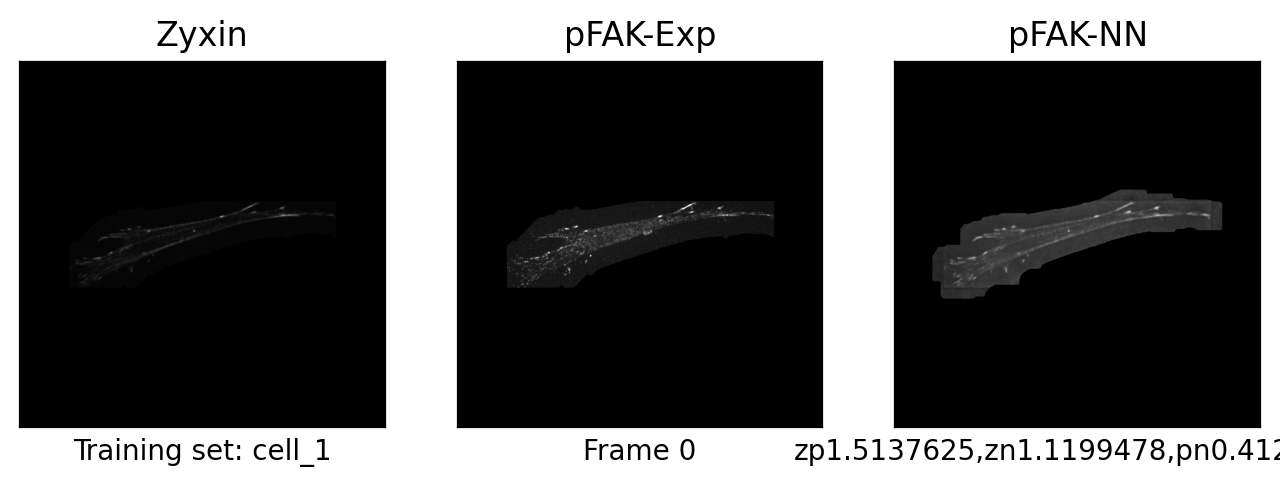

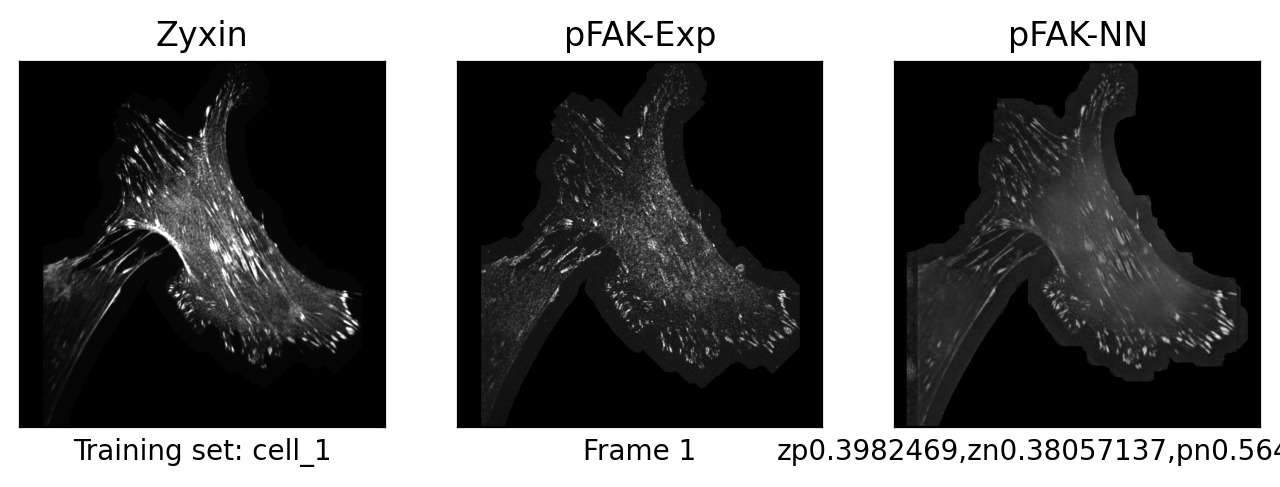

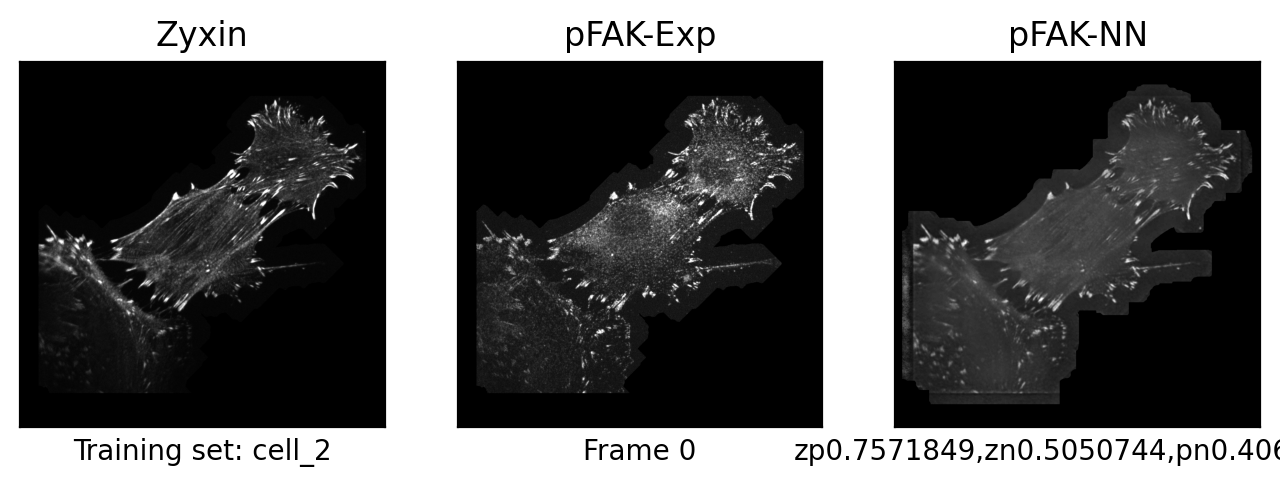

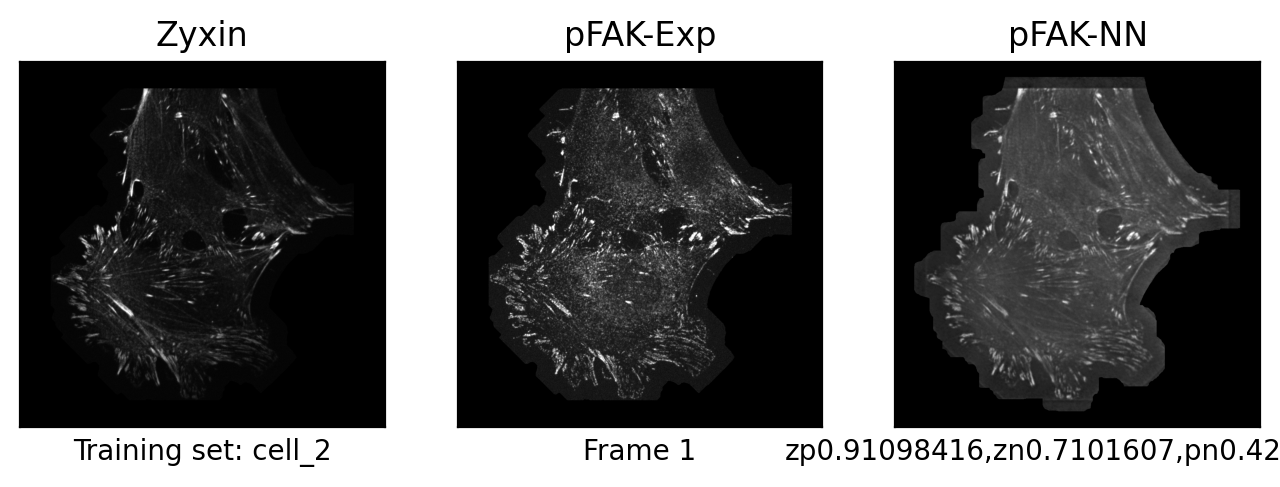

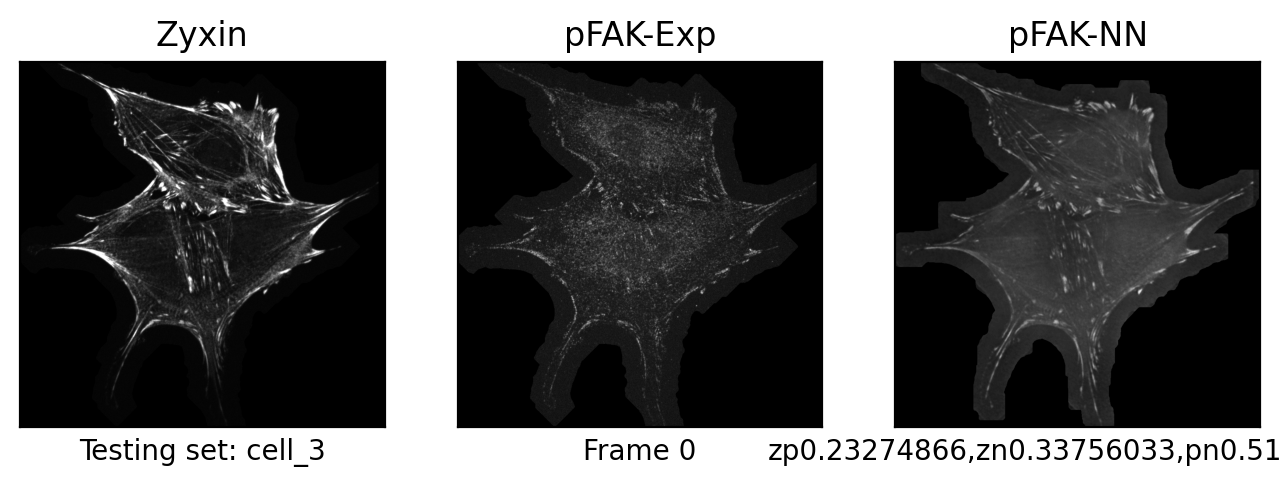

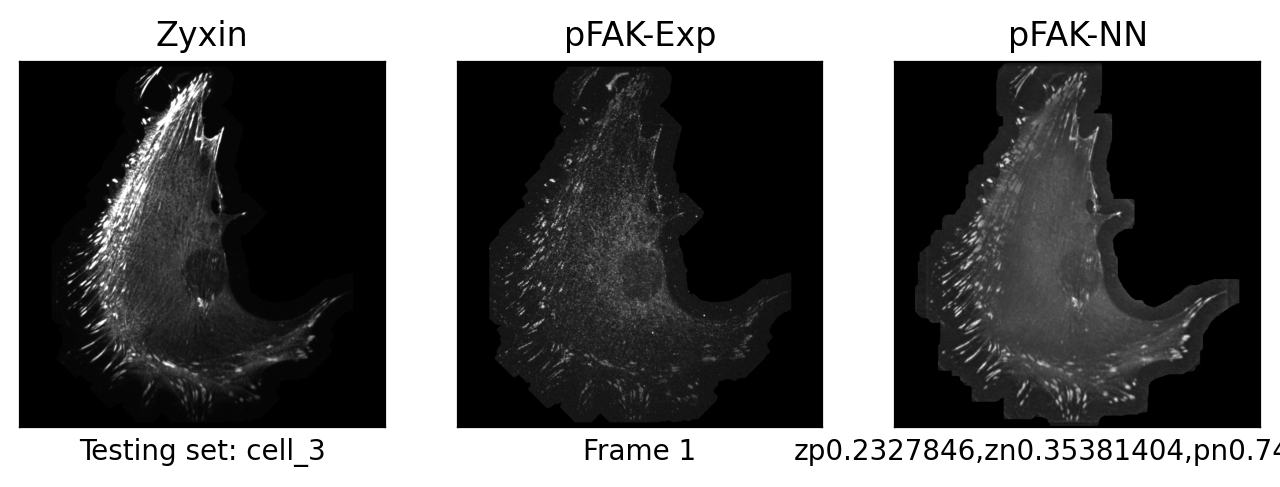

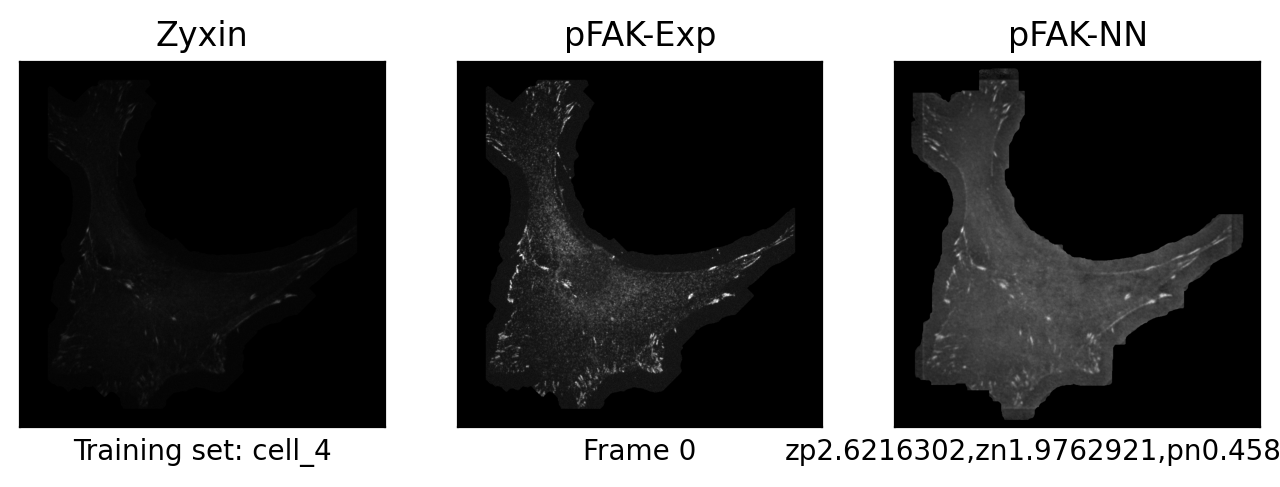

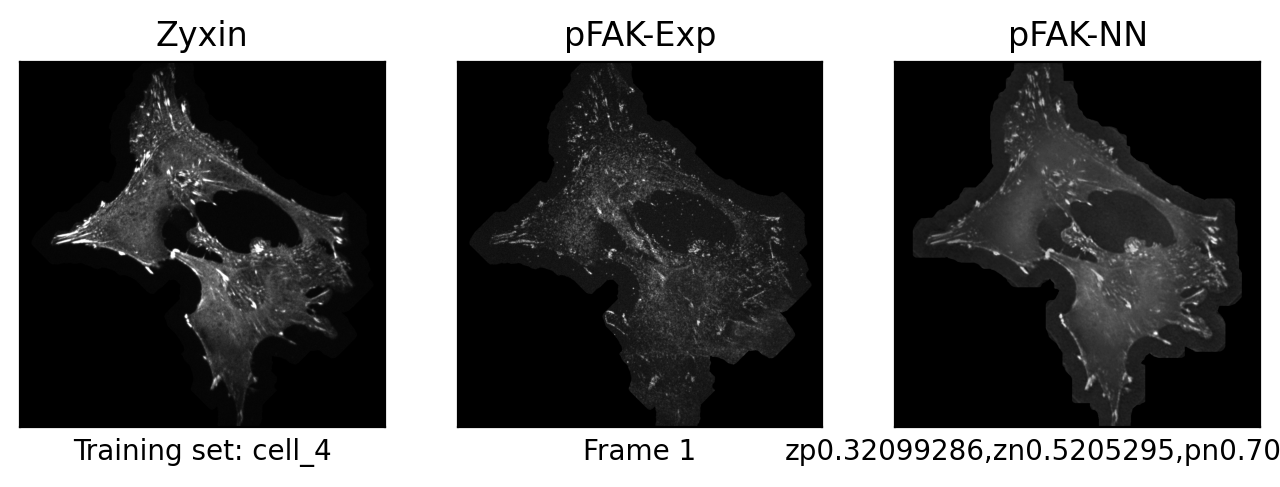

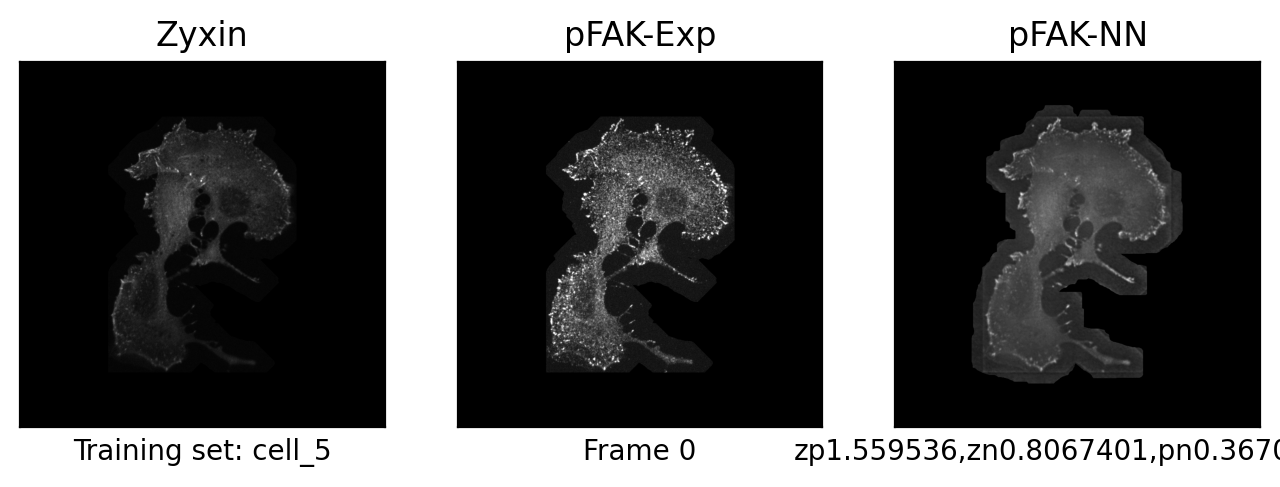

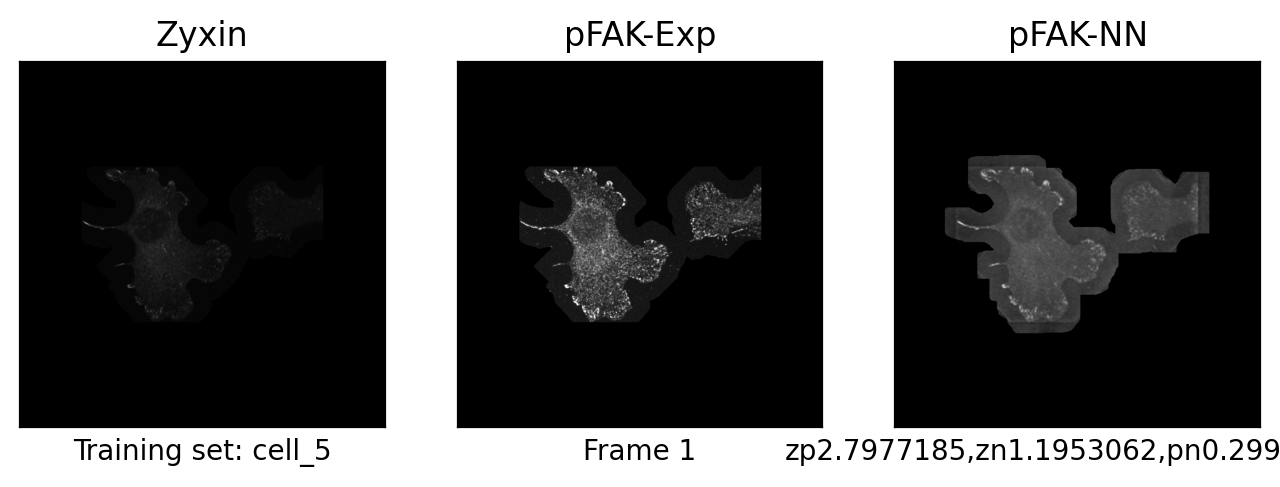

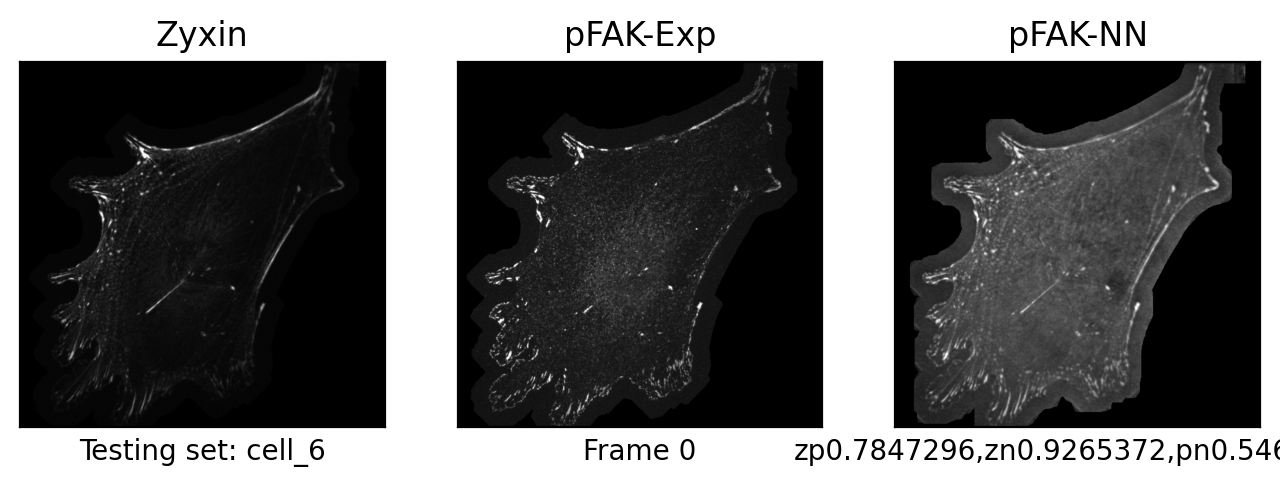

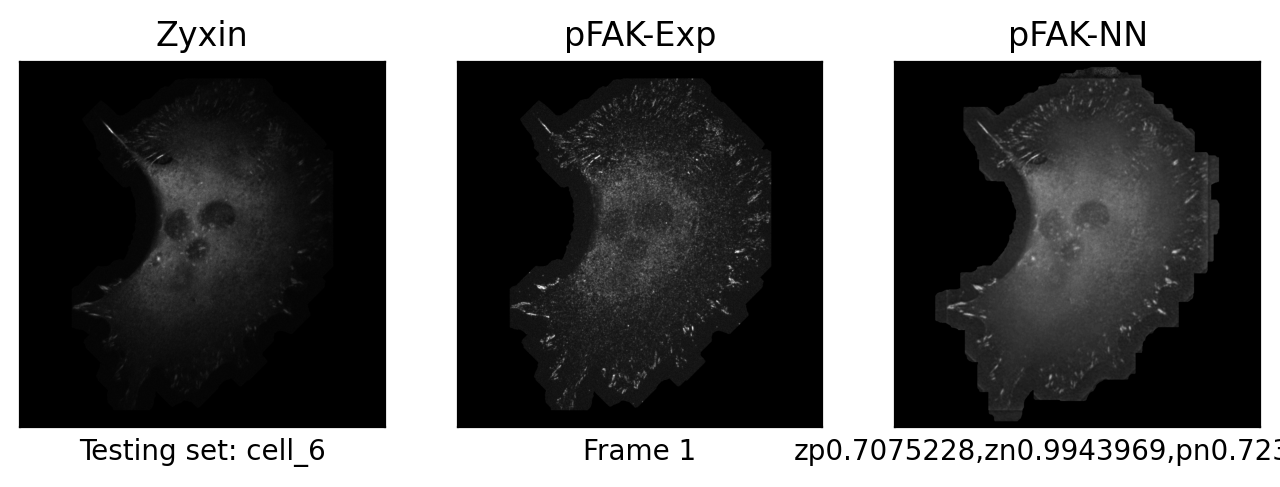

In [43]:
import tifffile
from utils.data67_processing import CellDataset, SubsetSampler

# modelinfo = torch.load('./tensorboard_logs/local_model_zyxin2pfakweighted_10ep_0/model.pt',  map_location=torch.device('cpu'))

# dataset_kwargs = modelinfo['dataset_kwargs']
# test_cells = dataset_kwargs['test_cells']

# modelinfo['dataset_kwargs']['root'] = '/net/projects/CLS/force_reference/data/240423_fixed_EGFP_zyxin_pFAK/normed_data_npy'
# modelinfo['dataset_kwargs']['transform_kwargs']['crop_size'] = 1024
# modelinfo['dataset_kwargs']['transform_kwargs']['rotate'] = False

# model = UNet(**modelinfo['model_kwargs'], model_idx = 0)

# model.load_state_dict(modelinfo['model'])




# fig,ax=plt.subplots(1,3,figsize=(3*3, 3*1), dpi=200)

model = models['zyxin1']

eval_dataset_kwargs = dataset_kwargs
eval_dataset_kwargs['transform_kwargs']['crop_size'] = 1024
eval_dataset_kwargs['exclude_frames'] = None
dataset = dp.CellDataset( **eval_dataset_kwargs )


# dataset = CellDataset(**modelinfo['dataset_kwargs'])

sampler = SubsetSampler(np.arange(len(dataset)))
loader = torch.utils.data.DataLoader(dataset, 
    batch_size=1,
    shuffle=False,
    sampler=sampler,
    pin_memory=True)

for cell in ['cell_1','cell_2','cell_3','cell_4','cell_5','cell_6']:
    for frame in range(2):  

        idx = np.sort(dataset.info[dataset.info.folder==cell].index.values)
        idx = idx[frame]

        model.eval()
        model.to(torch.device('cuda:0'))

        sample = dataset[idx]
        for k in sample:
            sample[k] = sample[k].unsqueeze(0).to(torch.device('cuda:0'))

        preds = []
        for _ in range(5):
            pred = model(model.select_inputs(model.input_type, sample)).detach().cpu().numpy().squeeze()
            preds.append(pred)
            
        pred = np.mean(preds, axis=0) 
        target = sample['output'].detach().cpu().numpy().squeeze() 
        zyx = sample['zyxin'].detach().cpu().numpy().squeeze()
        pax = sample['actin'].detach().cpu().numpy().squeeze()
        mask= sample['mask'].detach().cpu().numpy().squeeze()

        from skimage.morphology import square, dilation
        dilate_mask = dilation(mask, square(64))>0

        zyxin_values = zyx[dilate_mask>0]
        pfak_values = pax[dilate_mask>0]
        nn_values = pred.squeeze()[0][dilate_mask>0]


        z_p_corr = normcorr(zyxin_values,pfak_values)
        z_n_corr = normcorr(zyxin_values,nn_values)
        p_n_corr = normcorr(pfak_values,nn_values)


        fig,ax=plt.subplots(1,3,figsize=(8, 3*1), dpi=200)

        ax[0].set_title('Zyxin')
        ax[0].imshow(zyx,  cmap='gray', vmax=1, vmin=0)
        if cell == 'cell_3' or cell == 'cell_6' :
            ax[0].set_xlabel('Testing set: ' + cell)
        else:
            ax[0].set_xlabel('Training set: ' + cell)
            
            
        ax[1].set_title('pFAK-Exp')
        ax[1].imshow(pax, cmap='gray', vmax=1, vmin=0)
        ax[1].set_xlabel('Frame '+ str(frame))
        
        ax[2].set_title('pFAK-NN')
        ax[2].imshow(pred.squeeze()[0]*dilate_mask,  cmap='gray', vmax=1, vmin=0)
        ax[2].set_xlabel('zp'+ "%.2f" % (z_p_corr) +',zn'+ "%.2f" % (z_n_corr) +',pn'+ "%.2f" % (p_n_corr))

        tifffile.imsave(os.path.join('../zyxin2pfak_results/tiff',cell + '_frame'+str(frame)+'.tif'),pred.squeeze()[0]/5)
        
        for a in ax.flat:
            a.set_xticks([])
            a.set_yticks([])
                    
        fig.savefig(os.path.join('../zyxin2pfak_results/plot', cell + '_frame'+str(frame)+'.png'))
        # plt.close(fig) 


In [40]:
def normcorr(input1,input2):
    input1_0_mean = input1 - np.mean(input1)
    input2_0_mean = input2 - np.mean(input2)
    corr = np.mean(input1_0_mean * input2_0_mean)
    corr_norm = corr/np.std(input1_0_mean)/np.std(input1_0_mean)
    return corr_norm


In [41]:
normcorr(zyxin_values,pfak_values)

0.920906

In [30]:
zyxin_values = zyx[dilate_mask>0]
pfak_values = pax[dilate_mask>0]
nn_values = pred[dilate_mask>0]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 1024

In [38]:
np.mean(zyxin_values)

0.067147456

In [17]:
pax.mean()

0.06922255

{'crop_size': 960, 'output_channels': 7, 'norm_output': {'rescale': 1, 'threshold': 0.0004}}
torch.Size([1, 1, 960, 960])
(1, 2, 960, 960)


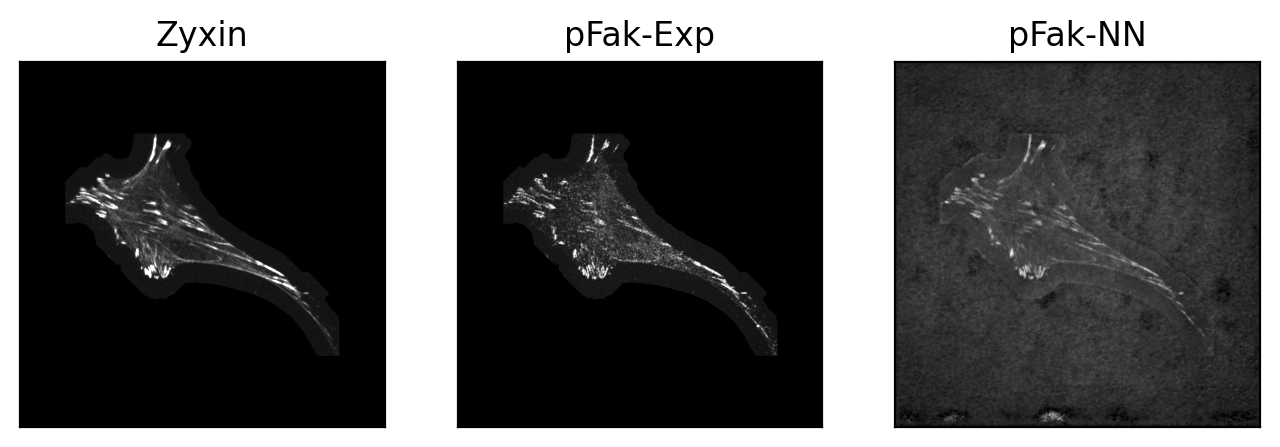

In [20]:
fig,ax=plt.subplots(1,3,figsize=(8, 3*1), dpi=200)

model = models['zyxin1']

eval_dataset_kwargs = dataset_kwargs
eval_dataset_kwargs['transform_kwargs']['crop_size'] = 960
eval_dataset_kwargs['exclude_frames'] = None
dataset_eval = dp.CellDataset( **eval_dataset_kwargs )

cell = 'cell_1'
frame = 5


idx = dataset_eval.info.index[(dataset_eval.info.folder==cell)&(dataset_eval.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.


sample = dataset_eval[idx] # get item

input_image = model.select_inputs(model.input_type, sample).unsqueeze(0).to(device)
print(input_image.shape)

pred = model(input_image).detach().cpu().numpy()

print(pred.shape)


ax[0].set_title('Zyxin')
ax[0].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=0.3, vmin=0)

ax[1].set_title('pFak-Exp')
ax[1].imshow(sample['actin'].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)

ax[2].set_title('pFak-NN')
ax[2].imshow(pred.squeeze()[0], origin='lower', cmap='gray', vmax=1, vmin=0)

for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])

### Performance on test cell

{'crop_size': 960, 'output_channels': 7, 'norm_output': {'rescale': 1, 'threshold': 0.0004}}
torch.Size([1, 1, 960, 960])
(1, 2, 960, 960)


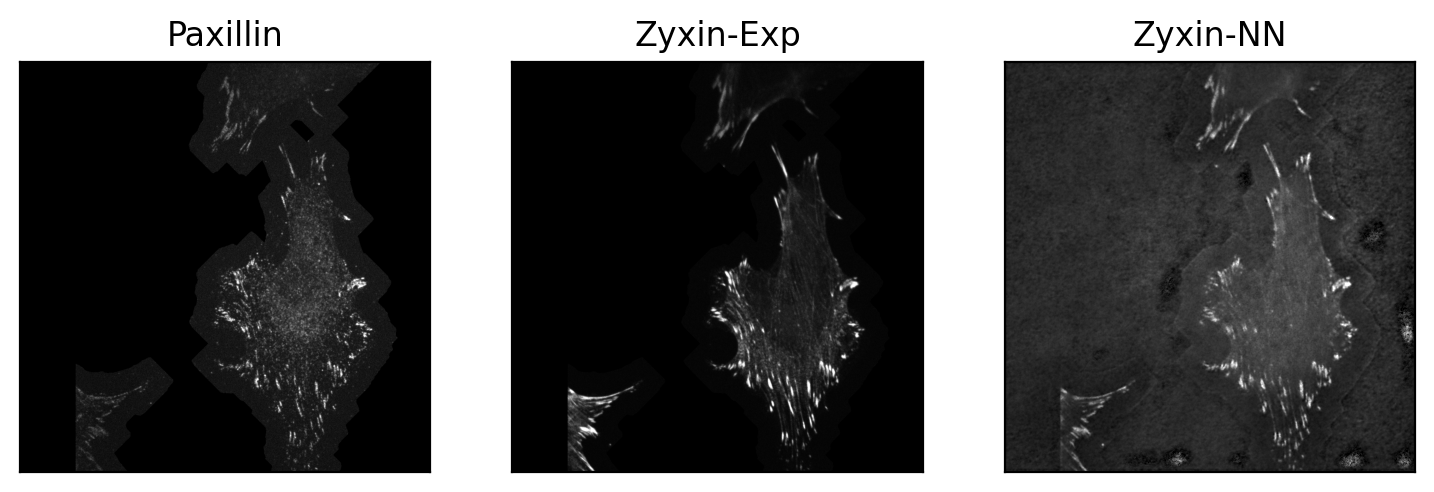

In [22]:
fig,ax=plt.subplots(1,3,figsize=(3*3, 3*1), dpi=200)

model = models['zyxin1']

eval_dataset_kwargs = dataset_kwargs
eval_dataset_kwargs['transform_kwargs']['crop_size'] = 960
eval_dataset_kwargs['exclude_frames'] = None
dataset_eval = dp.CellDataset( **eval_dataset_kwargs )

cell = 'cell_3'
frame = 250

idx = dataset_eval.info.index[(dataset_eval.info.folder==cell)&(dataset_eval.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.


sample = dataset_eval[idx] # get item

input_image = model.select_inputs(model.input_type, sample).unsqueeze(0).to(device)
print(input_image.shape)

pred = model(input_image).detach().cpu().numpy()

print(pred.shape)

ax[0].set_title('Paxillin')
ax[0].imshow(sample['actin'].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)

ax[1].set_title('Zyxin-Exp')
ax[1].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)

ax[2].set_title('Zyxin-NN')
ax[2].imshow(pred.squeeze()[0], origin='lower', cmap='gray', vmax=1, vmin=0)


for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])